In [1]:
import torch
import os

# Get the current path of the notebook
notebook_path = os.getcwd()

# Construct the path to the directory containing 'fit'
parent_path = os.path.join(notebook_path, '..')
os.chdir(parent_path)
import sys
# Add this parent directory to the system path
sys.path.insert(0, parent_path)
from fit.fit_jet_fm import FM
import pytorch_lightning as pl
import torch
# from utils.dataloader_jetnet import PointCloudDataloader
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from utils.helpers import get_hists, mass
# from utils.dataloader_jetnet import PointCloudDataloader
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator, FuncFormatter


from torch.nn import functional as FF
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import BatchSampler, DataLoader, Dataset, Sampler
from tqdm import tqdm
import yaml
import wandb
from dataloader_calo import PointCloudDataloader


/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/gpfs/dust/maxwell/user/kaechben/.conda/envs/mdma-cfm/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/late

ModuleNotFoundError: No module named 'dataloader_calo'

# CaloChallenge



/beegfs/desy/user/kaechben/.conda/envs/torch_wandb/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /beegfs/desy/user/kaechben/.conda/envs/torch_wandb/l ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/beegfs/desy/user/kaechben/.conda/envs/torch_wandb/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboa

Validation: 0it [00:00, ?it/s]

Validation DataLoader 0: 100%|██████████| 3125/3125 [01:52<00:00, 27.75it/s]


Traceback (most recent call last):
  File "/home/kaechben/MDMACalo/fit.py", line 365, in calo_evaluation
    self.plot.plot_calo(self.hists_fake, self.hists_real, weighted=False)
  File "/home/kaechben/MDMACalo/helpers.py", line 295, in plot_calo
    self.summary.log_image("{}ratio".format("weighted " if weighted else "unweighted "), [fig],self.step)
AttributeError: 'CSVLogger' object has no attribute 'log_image'


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        features/R         │   0.0031947633941524223   │
│    features/R_weighted    │   0.0031947633941524223   │
│      features/alpha       │  4.2014552644401536e-05   │
│  features/alpha_weighted  │  4.2014552644401536e-05   │
│        features/z         │   0.0024444790117903745   │
│    features/z_weighted    │   0.0024444790117903745   │
│        features_E         │   0.0019574033884328466   │
│          min_w1p          │   0.0019096650867550112   │
│     min_weighted_w1p      │   0.001893752319529066    │
│            w1p            │   0.0019096650867550112   │
│       weighted_w1p        │   0.001893752319529066    │
│        weighted_z         │   0.0024444790117903745   │
└───────────────────────────┴───────────────────────────┘

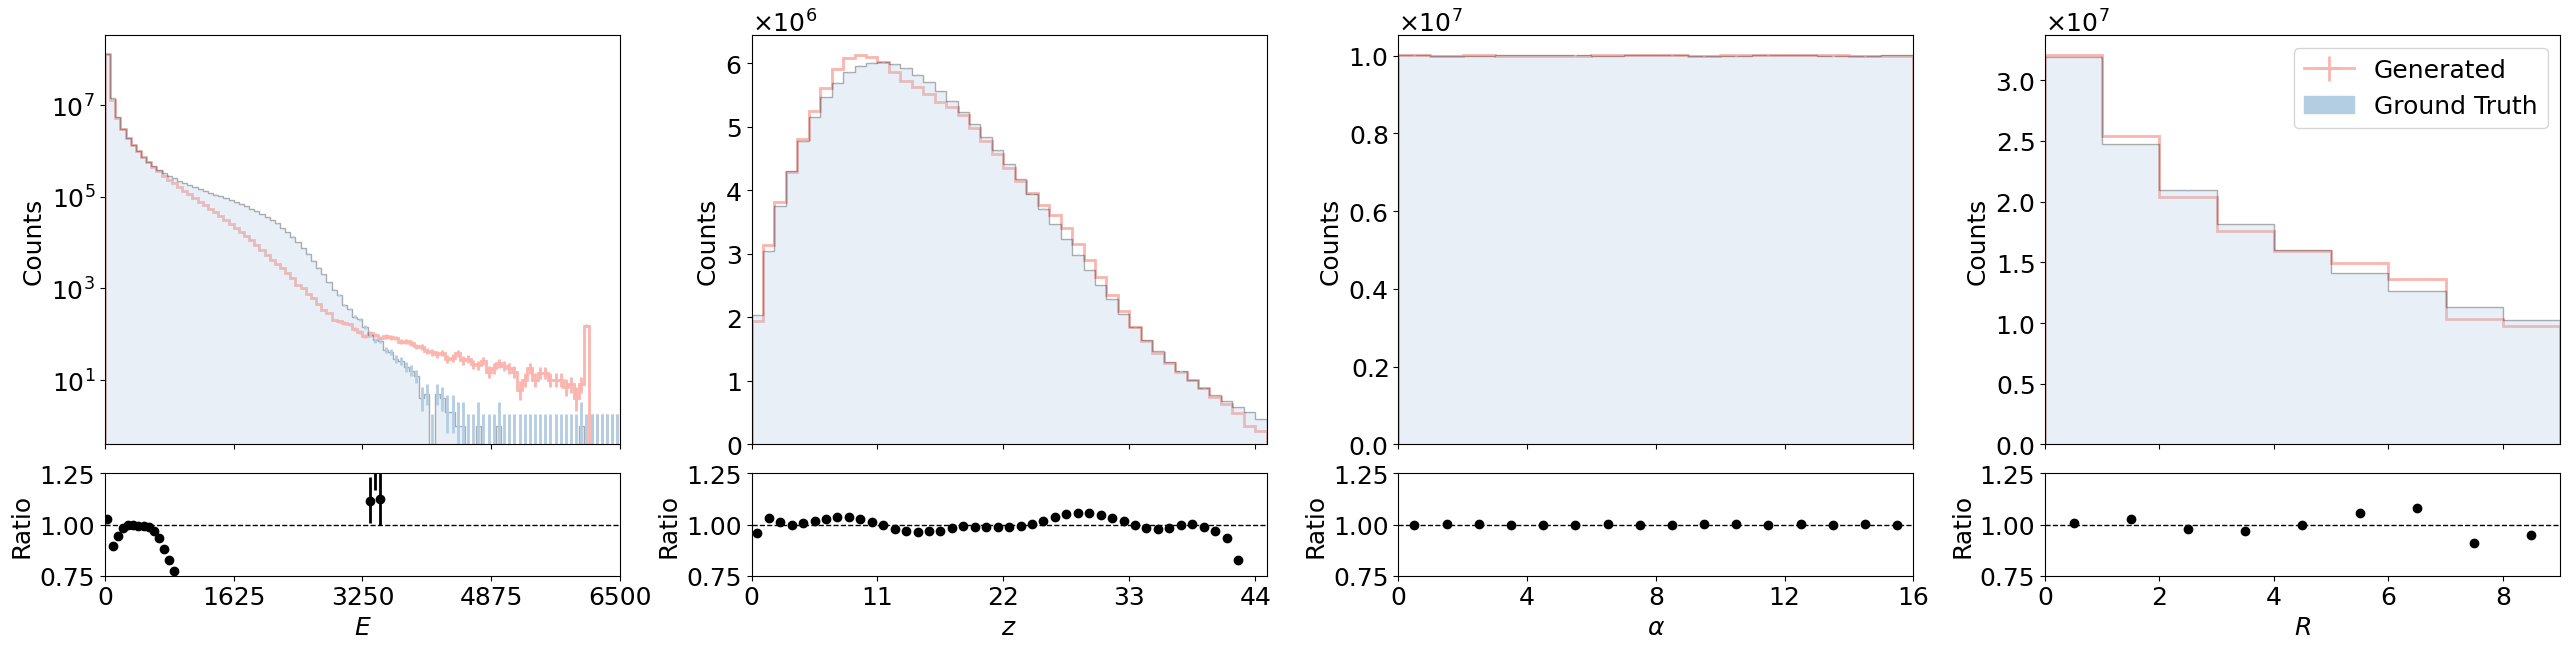

In [2]:

%matplotlib inline
torch.set_float32_matmul_precision('medium' )
from preprocess import LogitTransformer, ScalerBase,DQLinear, Cart, SqrtTransformer
config["augmentation"]=False
trainer = pl.Trainer(devices=1,accelerator="gpu")
fakes=[]
conds=[]
masks=[]
batches=[]
trainer.validate(model,dataloaders=data_module.val_dataloader(),verbose=True)
batches.extend(model.batch)
fakes.extend(model.fake)
conds.extend(model.conds)
masks.extend(model.masks)

In [3]:
fakes=torch.cat([x.reshape(-1,4) for x in model.fake])
reals=torch.cat([x.reshape(-1,4) for x in model.batch])


In [8]:
import torch_scatter
from math import prod
def convert_4d_indices_to_1d(indices, dims):
    # indices is a tensor of shape [num_indices, 4]
    # dims is the shape of the original tensor (e.g., [dim0, dim1, dim2, dim3])
    assert len(dims) == 4, "dims must be length 4"
    assert indices.shape[1] == 4, "indices must be 2D with second dimension 4"
    indices_1d = indices[:, 0] * dims[1] * dims[2] * dims[3] + indices[:, 1] * dims[2] * dims[3] + indices[:, 2] * dims[3] + indices[:, 3]
    return indices_1d
def complement(t1,t2):
    combined = torch.cat((t1, t2))
    uniques, counts = combined.unique(return_counts=True)
    difference = uniques[counts == 1]
    # intersection = uniques[counts > 1]
    return difference
def complement_idx(idx, dim):
    """
    Compute the complement: set(range(dim)) - set(idx).
    idx is a multi-dimensional tensor, find the complement for its trailing dimension,
    all other dimension is considered batched.
    Args:
        idx: input index, shape: [N, *, K]
        dim: the max index for complement
    """
    a = torch.arange(dim, device=idx.device)
    ndim = idx.ndim
    dims = idx.shape
    n_idx = dims[-1]
    dims = dims[:-1] + (-1, )
    for i in range(1, ndim):
        a = a.unsqueeze(0)
    a = a.expand(*dims)
    masked = torch.scatter(a, -1, idx, 0)
    compl, _ = torch.sort(masked, dim=-1, descending=False)
    compl = compl.permute(-1, *tuple(range(ndim - 1)))
    compl = compl[n_idx:].permute(*(tuple(range(1, ndim)) + (0,)))
    return compl
def voxelize(batch,mask,cond):
    empty = torch.zeros((batch.shape[0],*dims), dtype=batch.dtype, device=batch.device)
    # Get the valid hits
    valid_hits = batch[~mask]
    valid_coordinates=valid_hits[:,1:].long().t()
    shower_index=torch.arange(batch.shape[0]).repeat_interleave((~mask).float().sum(1).reshape(-1).int())

    indices=torch.cat((shower_index.unsqueeze(1),valid_coordinates.t()),dim=1)
    moritz=torch.arange(batch.shape[0]*dims[0]*dims[1]*dims[2]).reshape(*empty.shape)
    scatter_index=moritz[indices[...,0],indices[...,1],indices[...,2],indices[...,3]]

    vox=torch_scatter.scatter_add(src=valid_hits[:,0], index=scatter_index,dim_size=prod(dims)*batch.shape[0])
    return vox.reshape(batch.shape[0],*dims)
voxs=[]
conds=[]
# batches=[]
middle=True
model_name="mdma_fm_calo"

bins=[45,16,9] if middle else [45,50,18]
dims=bins
fake_pc=torch.load("/beegfs/desy/user/kaechben/data_generated/calochallenge_{}_{}.pt".format(model_name,"big" if not middle else "middle"))
reals_pc=torch.load("/beegfs/desy/user/kaechben/data_generated/calochallenge_reals_{}_{}.pt".format(model_name,"big" if not middle else "middle"))
masks=torch.load("/beegfs/desy/user/kaechben/data_generated/calochallenge_masks_{}_{}.pt".format(model_name,"big" if not middle else "middle"))
conds=torch.load("/beegfs/desy/user/kaechben/data_generated/calochallenge_conds_{}_{}.pt".format(model_name,"big" if not middle else "middle"))
real_voxs=[]
reals_plot=[]
fakes_plot=[]
for fake,mask,cond,real in zip(fake_pc,masks,conds,reals_pc):

    fake[...,1:]=torch.clamp(fake[...,1:].cpu(),torch.zeros(3).cpu(),torch.tensor([bins[0]-1,bins[1]-1,bins[2]-1],device=fake.device).cpu())
    real[...,1:]=torch.clamp(real[...,1:].cpu(),torch.zeros(3).cpu(),torch.tensor([bins[0]-1,bins[1]-1,bins[2]-1],device=real.device).cpu())


    vox=voxelize(fake.cpu().clone(),mask.cpu().clone(),cond.cpu().clone())

    voxs.append(vox)
    # conds.append(cond[...,0].cpu().clone())

    real_vox=voxelize(real.cpu().clone(),mask.cpu().clone(),cond.cpu().clone())
    real_voxs.append(real_vox)
    reals_plot.append(real.reshape(-1,4))
    fakes_plot.append(fake.reshape(-1,4))
# for temp,mask,cond in zip(model.batch,model.masks,model.conds):
#     x=temp.clone()
#     x[...,1:]=torch.clamp(x[...,1:].cpu(),torch.zeros(3).cpu(),torch.tensor([model.num_z-1,model.num_alpha-1,model.num_R-1],device=temp.device).cpu())
#     vox=voxelize(x.cpu(),mask.cpu(),cond.cpu())
#     batches.append(vox)
#     conds.append(cond[...,0].cpu())
# fakes=torch.cat(voxs).cpu()
# reals=torch.cat(real_voxs).cpu()

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45.]


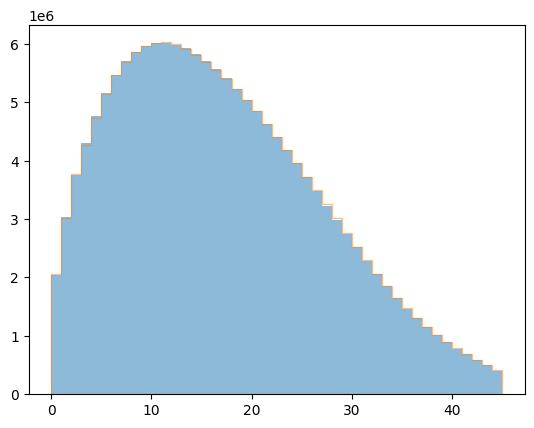

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]


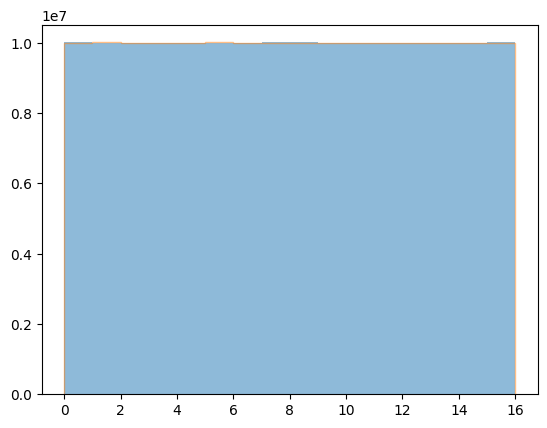

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


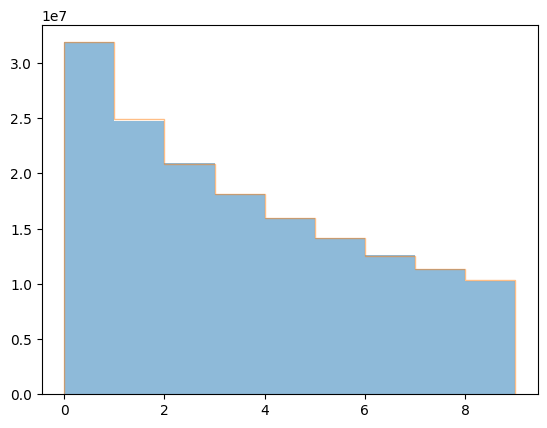

In [7]:
import matplotlib.pyplot as plt
import numpy as np
plot_bins=[6000,45,16,9]
real_plot=torch.cat(reals_plot)
fake_plot=torch.cat(fakes_plot)
real_plot=real_plot[real_plot[:,0]>0]

fake_plot=fake_plot[fake_plot[:,0]>0]
for i in range(1,4):

    _,bins,_=plt.hist(real_plot[:,i].numpy(),bins=np.linspace(0,plot_bins[i],plot_bins[i]+1),alpha=0.5)
    print(bins)
    plt.hist(fake_plot[:,i].numpy(),bins=bins,alpha=0.5,histtype="step")
    plt.show()

In [ ]:
from torch_geometric.data import Data, Batch
batchl=[]
for fake, mask, cond in zip(fake_pc, masks, conds):

    batch=Batch.from_data_list([ Data(x=e[~m]) for e,m in zip(fake,mask)])
    batchl.append(batch)

import caloutils
batch_list= SuperBatch.from_batch_list(batchl )

s=caloutils.processing.shift_sum_multi_hits(batch_list)
from caloutils.processing import pc_to_voxel
vox=pc_to_voxel(s)

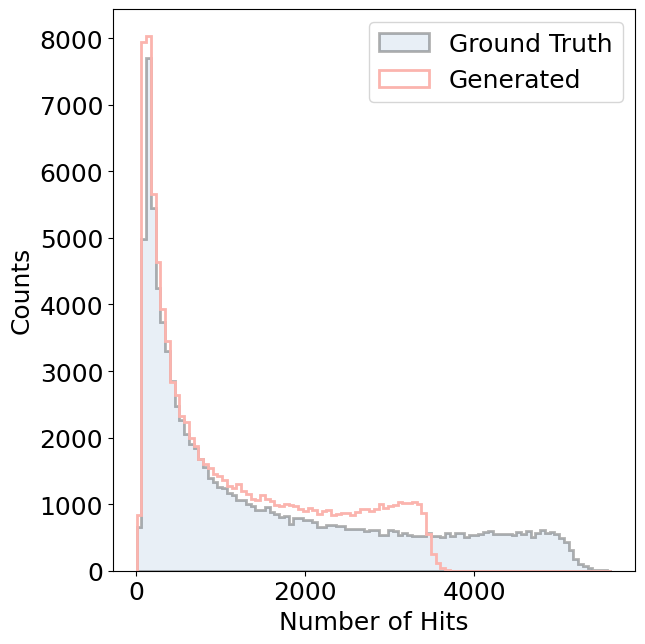

In [ ]:
import matplotlib as mpl
import seaborn as sns

n_fake=(torch.cat(voxs).reshape(-1,plot_bins[1]*plot_bins[2]*plot_bins[3])>0).sum(1)
n_real=(torch.cat(real_voxs).reshape(-1,plot_bins[1]*plot_bins[2]*plot_bins[3])>0).sum(1)
plt.figure(figsize=(6.4,6.4))

_,b,_=plt.hist(n_real.cpu().numpy(),label="Ground Truth",bins=100,alpha=0.3,color="C1",edgecolor="black",histtype="stepfilled",linewidth=2)
plt.hist(n_fake.cpu().numpy(),label="Generated",bins=b,alpha=1,color="C0",histtype="step",lw=2)

fig_size1=[6.4, 6.4]

mpl.rcParams['lines.linewidth'] = 2
font = { "size": 18}#"family": "normal",
mpl.rc("font", **font)
mpl.rc('lines', linewidth=2)
sns.set_palette("Pastel1")
plt.legend()
#plt.title("Shower Multiplicity",fontsize=28, fontweight="bold")
plt.xlabel("Number of Hits")
plt.ylabel("Counts")
plt.tight_layout(pad=0.3)
#plt.savefig("calo_n.pdf",format="pdf")



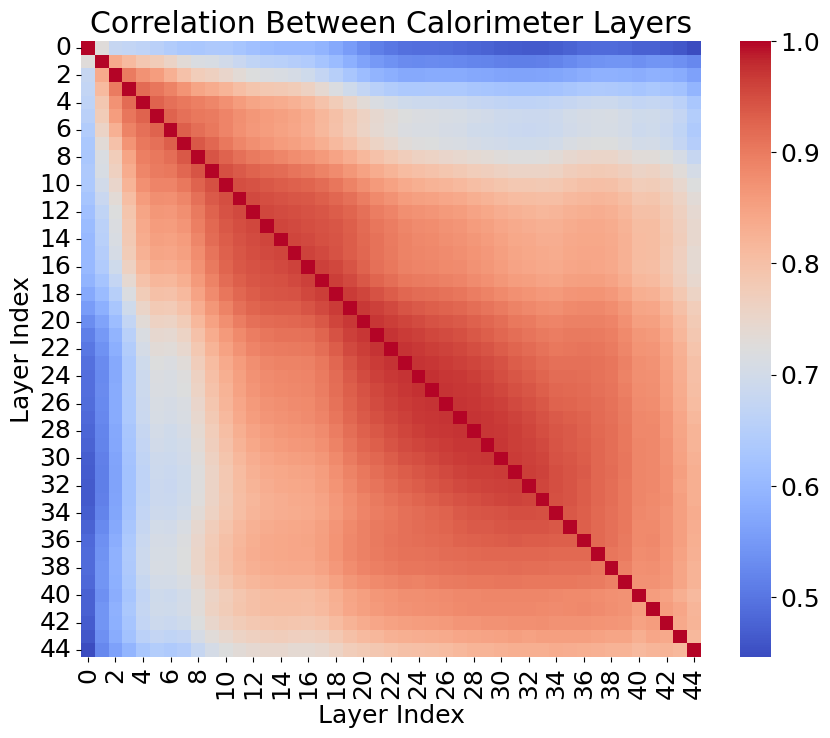

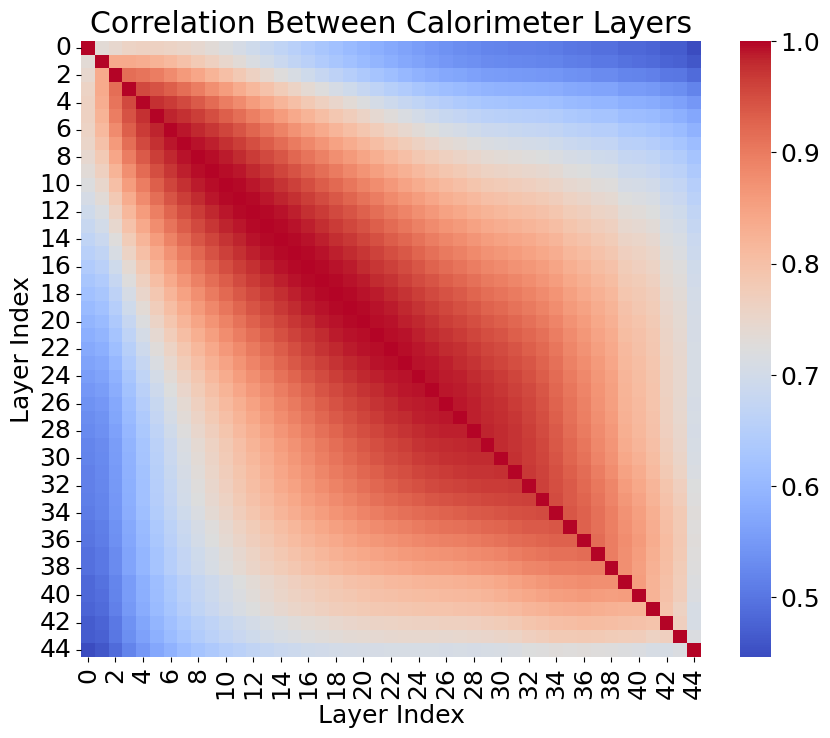

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate a 4D tensor for demonstration

def compute_correlation_matrix(tensor):
    # Sum over the angular and radial layers
    summed_tensor = tensor.sum(axis=(2, 3))

    # Compute the correlation matrix across the batch dimension
    correlation_matrix = np.corrcoef(summed_tensor, rowvar=False)

    return correlation_matrix

# Compute the correlation matrix
correlation_matrix = compute_correlation_matrix(torch.cat(fake).numpy())

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
#plt.title("Correlation Between Calorimeter Layers")
plt.xlabel("Layer Index")
plt.ylabel("Layer Index")
plt.show()
correlation_matrix = compute_correlation_matrix(torch.cat(batches).numpy())

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, fmt=".2f")
#plt.title("Correlation Between Calorimeter Layers")
plt.xlabel("Layer Index")
plt.ylabel("Layer Index")
plt.show()

In [77]:
import h5py
E=torch.cat(conds)[:,0,0].cpu()
fake=vox.clone()
with h5py.File("/beegfs/desy/user/kaechben/calochallenge/{}_dataset_2.hdf5".format(model_name), "w") as h5_file:

    N = len(fake) # find the length of my dataset
    h5_file.create_dataset('incident_energies', shape=(N, ), dtype=np.float64, data=(E+10).exp().double().cpu().numpy())
    h5_file.create_dataset('showers', shape=(N,fake.shape[3]*fake.shape[1]*fake.shape[2] ), dtype=np.float64, data=fake.double().reshape(-1,fake.shape[3]*fake.shape[1]*fake.shape[2]).numpy(), )#compression="gzip", compression_opts=9

In [21]:
from collections import defaultdict
from typing import Optional

import torch
import torch_scatter
from torch import LongTensor, Tensor
from torch_geometric.data import Batch
from torch_geometric.data.collate import collate


class SuperBatch(Batch):
    def __init__(self, batch_idx: LongTensor, **kwargs) -> None:
        super().__init__(**kwargs)

        if not batch_idx.dtype == torch.long:
            raise Exception("Batch index dtype must be torch.long")
        if not (batch_idx.diff() >= 0).all():
            raise Exception("Batch index must be increasing")
        if not batch_idx.dim() == 1:
            raise Exception()

        self.batch = batch_idx
        self.ptr = self._ptr_from_batchidx(batch_idx)
        self._num_graphs = int(self.batch.max() + 1)

        self._slice_dict = defaultdict(dict)
        self._inc_dict = defaultdict(dict)

    @classmethod
    def from_batch_list(
        cls,
        batches: list[Batch],
        follow_batch: Optional[list[str]] = None,
        exclude_keys: Optional[list[str]] = None,
    ):
        res, slice_dict, inc_dict = collate(
            cls,
            data_list=batches,
            increment=True,
            add_batch=not isinstance(batches[0], Batch),
            follow_batch=follow_batch,
            exclude_keys=exclude_keys,
        )

        res._slice_dict = slice_dict
        res._inc_dict = inc_dict

        del res._slice_dict["batch"], res._inc_dict["batch"]

        res.ptr = cls._ptr_from_batchidx(cls, res.batch)

        for k in set(res.keys()) - {"batch", "ptr"}:
            # slice_shift = [0] + [be._slice_dict[k][-1] for be in batches ]
            res._slice_dict[k] = pad_zero(
                torch.concat([be._slice_dict[k].diff() for be in batches]).cumsum(0)
            )
            if k != "edge_index":
                inc_shift = pad_zero(
                    torch.tensor([sum(be._inc_dict[k]) for be in batches])
                ).cumsum(0)
            else:
                inc_shift = pad_zero(
                    torch.tensor([be.num_nodes for be in batches])
                ).cumsum(0)

            res._inc_dict[k] = torch.cat(
                [
                    be._inc_dict[k] + inc_shift[ibatch]
                    for ibatch, be in enumerate(batches)
                ]
            )
        return res

    def _ptr_from_batchidx(self, batch_idx: LongTensor):
        # Construct the ptr to adress single graphs
        assert batch_idx.dtype == torch.long
        # graph[idx].x== batch.x[batch.ptr[idx]:batch.ptr[idx]+1]
        # Get delta with diff
        # Get idx of diff >0 with nonzero
        # shift by -1
        # add the batch size -1 as last element and add 0 in front
        dev = batch_idx.device
        ptr = torch.concatenate(
            (
                torch.tensor(0).long().to(dev).unsqueeze(0),
                (batch_idx.diff()).nonzero().reshape(-1) + 1,
                torch.tensor(len(batch_idx)).long().to(dev).unsqueeze(0),
            )
        )
        return ptr

    def add_node_attr(self, attrname: str, attr: Tensor):
        assert attr.device == self.batch.device
        batch_idxs = self.batch

        self[attrname] = attr
        out = torch_scatter.scatter_add(
            torch.ones(len(attr), dtype=torch.long),
            batch_idxs,
            dim=0,
        )
        out = out.cumsum(dim=0)
        self._slice_dict[attrname] = pad_zero(out)

        self._inc_dict[attrname] = torch.zeros(self._num_graphs, dtype=torch.long)

    def add_graph_attr(self, attrname: str, attr: Tensor):
        assert attr.device == self.batch.device

        self[attrname] = attr
        self._slice_dict[attrname] = torch.arange(
            self.num_graphs + 1, dtype=torch.long
        )

        self._inc_dict[attrname] = torch.zeros(self.num_graphs, dtype=torch.long)

    def set_edge_attr(self, edge_attr: LongTensor, batchidx_per_edge: LongTensor):
        assert batchidx_per_edge.dtype == torch.long
        assert (
            hasattr(self, "edge_index") and self["edge_index"].dtype == torch.long
        )
        self.edge_attr = edge_attr
        self._slice_dict["edge_attr"] = self._slice_dict["edge_index"]
        self._inc_dict["edge_attr"] = torch.zeros(self.num_graphs)

    def set_edges(self, edges: LongTensor, batchidx_per_edge: LongTensor):
        assert edges.dtype == batchidx_per_edge.dtype == torch.long
        assert edges.device == batchidx_per_edge.device == self.batch.device
        assert (
            batchidx_per_edge.diff() >= 0
        ).all(), "Edges must be ordered by batch"
        if self.edge_index is None:
            self.edge_index = torch.empty(
                2, 0, dtype=torch.long, device=self.batch.device
            )
        # Edges must be shifted by the number sum of the nodes in the previous graphs
        edges += self.ptr[batchidx_per_edge]
        self.edge_index = torch.hstack((self.edge_index.clone(), edges))
        # Fix _slice_dict
        edges_per_graph = batchidx_per_edge.unique(return_counts=True)[1]
        self._slice_dict["edge_index"] = pad_zero(edges_per_graph.cumsum(0)).cpu()
        self._inc_dict["edge_index"] = self.ptr[:-1].cpu()


def pad_zero(arr: torch.Tensor):
    return torch.cat(
        [torch.tensor(0, dtype=arr.dtype, device=arr.device).unsqueeze(0), arr]
    )

TypeError: 'method' object is not iterable

AttributeError: module 'caloutils' has no attribute 'shift_sum_hits'

NameError: name 'pc_to_voxel' is not defined

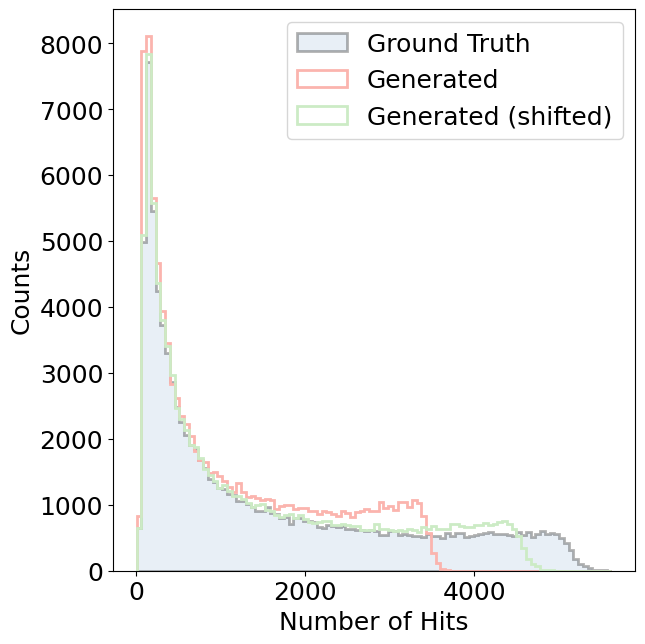

In [32]:
import matplotlib as mpl
import seaborn as sns
n_fake=(torch.cat(voxs).reshape(-1,plot_bins[1]*plot_bins[2]*plot_bins[3])>0).sum(1)

n_fake_mv=(vox.reshape(-1,plot_bins[1]*plot_bins[2]*plot_bins[3])>0).sum(1)
n_real=(torch.cat(real_voxs).reshape(-1,plot_bins[1]*plot_bins[2]*plot_bins[3])>0).sum(1)
plt.figure(figsize=(6.4,6.4))

_,b,_=plt.hist(n_real.cpu().numpy(),label="Ground Truth",bins=100,alpha=0.3,color="C1",edgecolor="black",histtype="stepfilled",linewidth=2)
plt.hist(n_fake.cpu().numpy(),label="Generated",bins=b,alpha=1,color="C0",histtype="step",lw=2)
plt.hist(n_fake_mv.cpu().numpy(),label="Generated (shifted)",bins=b,alpha=1,color="C2",histtype="step",lw=2)
fig_size1=[6.4, 6.4]

mpl.rcParams['lines.linewidth'] = 2
font = { "size": 18}#"family": "normal",
mpl.rc("font", **font)
mpl.rc('lines', linewidth=2)
sns.set_palette("Pastel1")
plt.legend()
#plt.title("Shower Multiplicity",fontsize=28, fontweight="bold")
plt.xlabel("Number of Hits")
plt.ylabel("Counts")
plt.tight_layout(pad=0.3)
#plt.savefig("calo_n.pdf",format="pdf")

